# Today we will compute the manifolds of the L1 and L2 Lagrange points in the Sun/Jupiter System

## We will be using the ThreeBodyProblem and DifferentialEquations packages

In [1]:
using ThreeBodyProblem
using DifferentialEquations
using Plots
using LinearAlgebra

# The first step is to define the system. ThreeBodyProblem.jl has built-in functions for common systems like Sun/Jupiter.

In [2]:
sys = sun_jupiter()

System(Body(1.98847e30, 695700.0, 0.0, 0.0, "Sun", :yellow), Body(1.898187e27, 69911.0, 7.782799587829314e8, 3.74355659124e8, "Jupiter", :red), 1.3271645321e11, 1.26690694941e8, 0.000953686364361088, 7.782799587829314e8, 695700.0, 69911.0, 3.74355659124e8, 7.782799587829314e8, 5.958055362400919e7, 13.06265067112951, 2.192435262277531e-7, "Sun/Jupiter")

## There's even a recipe to plot the system for us!

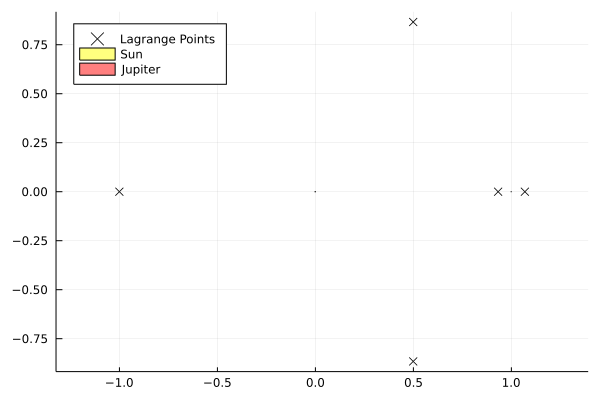

In [3]:
plot(sys)

## We can see the Lagrange Points, but where are the Sun and Jupiter? Turns out that the distance between them is so much larger than the radius of either one that it makes it hard to see them on a truly scaled picture. Let's scale the Sun and Jupiter to make them visible.

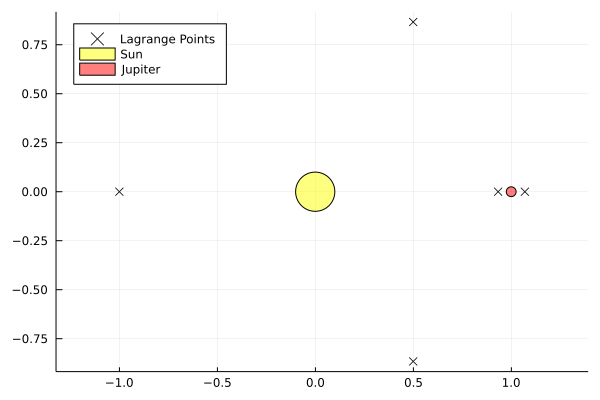

In [4]:
plot(sys, scaled = true)

## That's better! Now let's compute the L1 and L2 Lagrange points of our system

In [27]:
L1, L2 = computeLpts(sys)
# Declare state vectors for L1 and L2 (with zero velocity)
rv1 = [L1; zeros(3)] # state at Lagrange point L1 (zero velocity added on)
rv2 = [L2; zeros(3)] # state at Lagrange point L2

6-element Vector{Float64}:
 1.0688260003760226
 0.0
 0.0
 0.0
 0.0
 0.0

## The Lagrange points are equilibrium points in our dynamics. This means that an object placed there perfectly will stay there forever. But, Lagrange points L1, L2, and L3 are unstable, meaning if you perturb the object slightly, it may fall away. This is how we will generate the invariant manifolds.

## We first need to linearize the dynamics about these Lagrange points to determine which directions are stable and unstable

In [11]:
Φ₀ = I(6) # The initial State Transition Matrix (STM)

6×6 Diagonal{Bool, Vector{Bool}}:
 1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1

In [14]:
w₀ = vcat(rv1,reshape(Φ₀,36,1)) # Augmented state with state and STM

42×1 Matrix{Float64}:
 1.0688260003760226
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [15]:
# Set up the ODE problem
tspan = (0.,1.)
prob = ODEProblem(CR3BPstm!,w₀,tspan,sys)
sol = solve(prob, reltol=1e-6)

retcode: Success
Interpolation: automatic order switching interpolation
t: 9-element Vector{Float64}:
 0.0
 0.06187661456455127
 0.1673910454493878
 0.29427463537996057
 0.43772722555726384
 0.5971524031444055
 0.7692937627009795
 0.9521279942423803
 1.0
u: 9-element Vector{Matrix{Float64}}:
 [1.0688260003760226; 0.0; … ; 0.0; 1.0]
 [1.0688260003760226; -3.505181675306595e-20; … ; 0.0; 0.9930725459322669]
 [1.0688260003760226; -6.91750736640327e-19; … ; 0.0; 0.9496719478898074]
 [1.0688260003760226; -3.729700656367206e-18; … ; 0.0; 0.8471926897720776]
 [1.0688260003760226; -1.2038074845501917e-17; … ; 0.0; 0.6725384568336843]
 [1.0688260003760226; -2.8812785629330283e-17; … ; 0.0; 0.4206723075602172]
 [1.0688260003760226; -5.6540254672967e-17; … ; 0.0; 0.10633381873085544]
 [1.0688260003760226; -9.586170852158935e-17; … ; 0.0; -0.2391287217838828]
 [1.0688260003760226; -1.0744863779633213e-16; … ; 0.0; -0.3264895695096267]

In [19]:
# The STM after a period (Monodromy Matrix)
Φₜ = Matrix(reshape(sol.u[end][7:42],6,6))

6×6 Matrix{Float64}:
  6.93842  -0.971648    0.0       1.9751    1.20669     0.0
 -3.05465   0.380882    0.0      -1.20669  -0.0380468   0.0
  0.0       0.0        -0.32649   0.0       0.0         0.49659
 16.2862   -3.165       0.0       4.52503   2.97856     0.0
 -9.95007   0.0997917   0.0      -2.97856  -2.0325      0.0
  0.0       0.0        -1.79908   0.0       0.0        -0.32649

In [20]:
# last time step should match very closely with rv1
rvₜ = sol.u[end][1:6]
err = norm(rv1 - rvₜ)

3.5340776008744983e-16

In [22]:
# Compute the eigenvectors of the Monodromy Matrix
Λ,V = eigen(Φₜ,sortby=isreal) # Λ is vector of eigenvalues, V is matrix of eigenvectors
Yw = real(V[:,findall(isreal, Λ)]) # Eigenvectors corresponding to real eigenvalues
Λ = Λ[findall(isreal, Λ)] # Purely real eigenvalues (have 0.0 imaginary component)
Yws = Yw[:,findmin(real(Λ))[2]] # Eigenvector associated with stable eigenvalue λ < 1
Ywu = Yw[:,findmax(real(Λ))[2]] # Eigenvector associated with unstable eigenvalue λ > 1

6-element Vector{Float64}:
  0.33891979852359
 -0.19550046965718854
 -3.6440564580126118e-19
  0.7971628968640003
 -0.4598306779630337
  0.0

## We perturb our states in the stable and unstable directions

In [23]:
α = 1e-6

# L1 points
rv1up = rv1 + α*Ywu # unstable manifold + side
rv1un = rv1 - α*Ywu # unstable manifold - side
rv1sp = rv1 + α*Yws # stable manifold + side
rv1sn = rv1 - α*Yws # stable manifold - side

6-element Vector{Float64}:
  1.0688256614562242
 -1.9550046965718807e-7
 -4.023153889814862e-23
  7.97162896864001e-7
  4.598306779630327e-7
  0.0

## Next, we integrate our initial conditions forward in time for the +x and -x directions and backward in time for the +y and -y directions

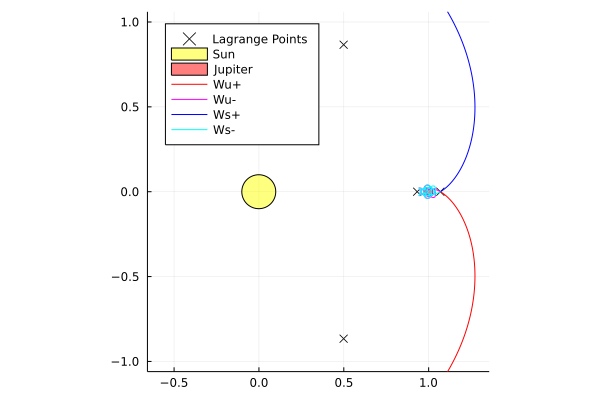

In [24]:
# Integrate trajectories for 2 Jupiter periods
tf = 2*2π
tspan_forward = (0.,tf) # make sure to add decimal points so tspan contains floating point values, not integers
tspan_back = (0.,-tf)
myreltol = 1e-12

# Set up the ODE Problems
prob1up = ODEProblem(CR3BPdynamics!,rv1up,tspan_forward,sys) # Unstable positive
prob1un = ODEProblem(CR3BPdynamics!,rv1un,tspan_forward,sys) # Unstable negative
prob1sp = ODEProblem(CR3BPdynamics!,rv1sp,tspan_back,sys) # Stable positive
prob1sn = ODEProblem(CR3BPdynamics!,rv1sn,tspan_back,sys) # Stable negative

# Solutions to the ODEs
sol1up = solve(prob1up, reltol=myreltol)
sol1un = solve(prob1un, reltol=myreltol)
sol1sp = solve(prob1sp, reltol=myreltol)
sol1sn = solve(prob1sn, reltol=myreltol)

plot(sys,scaled=true)
plot!(sol1up,vars=(1,2),label="Wu+",linecolor=:red)
plot!(sol1un,vars=(1,2),label="Wu-",linecolor=:magenta)
plot!(sol1sp,vars=(1,2),label="Ws+",linecolor=:blue)
plot!(sol1sn,vars=(1,2),label="Ws-",linecolor=:cyan)
plot!(aspect_ratio=1,ylims=[-1,1],xlims=[-0.6,1.3],legend=:topleft,flip=false)

## We can see two strands moving in towards the sun, but the rest is a jumbled mess. Let's zoom in to see what's going on. Also, I need to make sure things are scaled correctly, or Jupiter will look way too big.

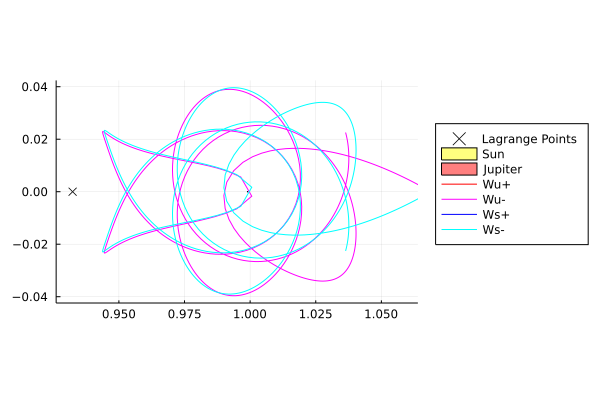

In [25]:
plot(sys)
plot!(sol1up,vars=(1,2),label="Wu+",linecolor=:red)
plot!(sol1un,vars=(1,2),label="Wu-",linecolor=:magenta)
plot!(sol1sp,vars=(1,2),label="Ws+",linecolor=:blue)
plot!(sol1sn,vars=(1,2),label="Ws-",linecolor=:cyan)
plot!(aspect_ratio=1,ylims=[-0.04,0.04],xlims=[0.93,1.06],legend=:outerright,flip=false)

## Now we look at the L2 point manifolds

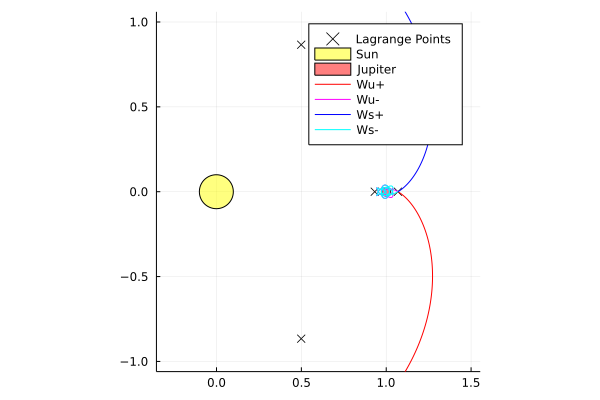

In [28]:
# L2 points
rv2up = rv2 + α*Ywu # unstable manifold + side
rv2un = rv2 - α*Ywu # unstable manifold - side
rv2sp = rv2 + α*Yws # stable manifold + side
rv2sn = rv2 - α*Yws # stable manifold - side

## Now we look at the L2 point manifolds
prob2up = ODEProblem(CR3BPdynamics!,rv2up,tspan_forward,sys) # Unstable positive
prob2un = ODEProblem(CR3BPdynamics!,rv2un,tspan_forward,sys) # Unstable negative
prob2sp = ODEProblem(CR3BPdynamics!,rv2sp,tspan_back,sys) # Stable positive
prob2sn = ODEProblem(CR3BPdynamics!,rv2sn,tspan_back,sys) # Stable negative

sol2up = solve(prob2up, reltol=1e-6)
sol2un = solve(prob2un, reltol=1e-6)
sol2sp = solve(prob2sp, reltol=1e-6)
sol2sn = solve(prob2sn, reltol=1e-6)

plot(sys, scaled=true)
plot!(sol2up,vars=(1,2),label="Wu+",linecolor=:red)
plot!(sol2un,vars=(1,2),label="Wu-",linecolor=:magenta)
plot!(sol2sp,vars=(1,2),label="Ws+",linecolor=:blue)
plot!(sol2sn,vars=(1,2),label="Ws-",linecolor=:cyan)
plot!(aspect_ratio=1,ylims=[-1.0,1.0],xlims=[-0.3,1.5],legend=:topright,flip=false)

## This time there are two strands moving out away from the Sun, along with another jumble around Jupiter. Let's zoom in again to take a look.

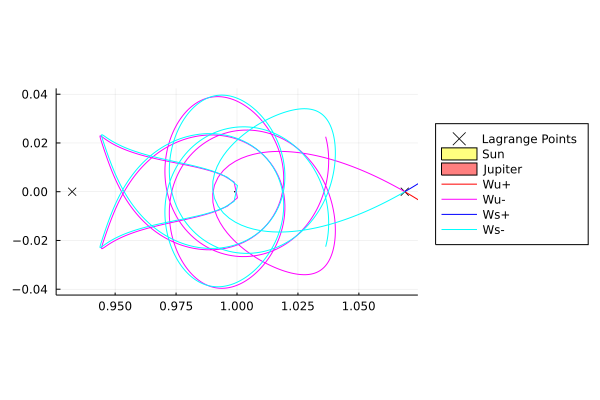

In [29]:
plot(sys)
plot!(sol2up,vars=(1,2),label="Wu+",linecolor=:red)
plot!(sol2un,vars=(1,2),label="Wu-",linecolor=:magenta)
plot!(sol2sp,vars=(1,2),label="Ws+",linecolor=:blue)
plot!(sol2sn,vars=(1,2),label="Ws-",linecolor=:cyan)
plot!(aspect_ratio=1,ylims=[-0.04,0.04],xlims=[0.93,1.07],legend=:outerright,flip=false)